In [1]:
!pip install simpeg

  Using cached simpeg-0.25.0-py3-none-any.whl
  Using cached pymatsolver-0.4.0-py3-none-any.whl
  Using cached discretize-0.12.0-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.0 kB)
  Using cached geoana-0.8.1-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (6.2 kB)
  Using cached libdlf-0.3.0-py3-none-any.whl.metadata (430 bytes)
Using cached discretize-0.12.0-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (1.3 MB)
Using cached geoana-0.8.1-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (211 kB)
Using cached libdlf-0.3.0-py3-none-any.whl (172 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [simpeg]2m4/5 [simpeg]ize]


## **Import the necessary modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model, download
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

### **Read the Data**

In [3]:
dobs = pd.read_excel("TDEM Data.xlsx")


In [4]:
print(dobs.head())

   Depth (m)  Resistivity (Ohm meters)
0          0                       8.0
1          2                       8.0
2          4                       8.0
3          6                       8.0
4          8                       8.0


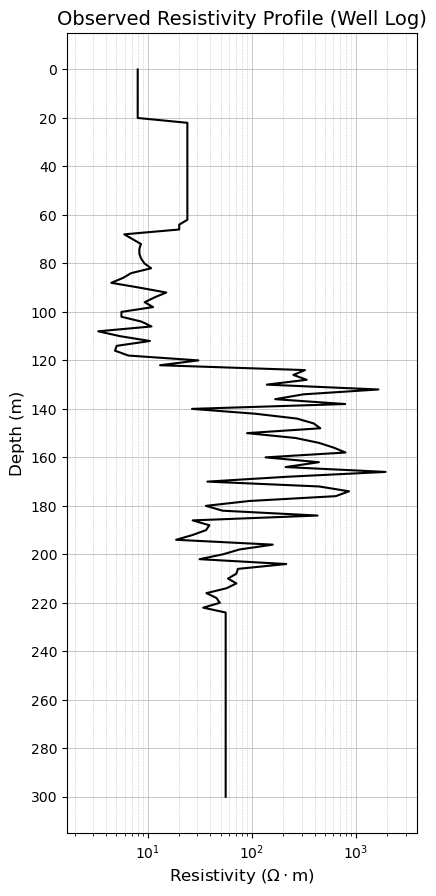

In [5]:
depth = dobs['Depth (m)'].values
resistivity = dobs['Resistivity (Ohm meters)'].values


fig = plt.figure(figsize=(5, 10)) # Using 5x10 for standard log size
ax = fig.add_axes([0.2, 0.1, 0.7, 0.8])

# Plot resistivity on a semi-log x-scale
ax.semilogx(resistivity, depth, "k-", lw=1.5, label='Raw Log')

# Standard log plot settings
ax.invert_yaxis()
ax.set_ylabel("Depth (m)", fontsize=12)
ax.set_xlabel(r"Resistivity ($\Omega \cdot \text{m}$)", fontsize=12) 

# Set tight x-limits for better visibility
ax.set_xlim(dobs['Resistivity (Ohm meters)'].min() * 0.5, dobs['Resistivity (Ohm meters)'].max() * 2) 

ax.set_yticks(np.arange(depth.min(), depth.max() + 1, 20))
ax.set_title("Observed Resistivity Profile (Well Log)", fontsize=14)
ax.grid(which="major", linestyle='-', linewidth=0.5)
ax.grid(which="minor", linestyle=':', linewidth=0.5)


plt.show()

### **Define the Survey**

In [6]:
# Source properties
source_location = np.array([0.0, 0.0, 30.0])  
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 10.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 30.0])  
receiver_orientation = "z"  # "x", "y" or "z"
times_ms = np.array([
    0.021, 0.026, 0.031, 0.036, 0.042, 0.048,
    0.055, 0.063, 0.073, 0.083, 0.096, 0.11,
    0.126, 0.145, 0.167, 0.192, 0.22, 0.253,
    0.29, 0.333, 0.383, 0.44, 0.505, 0.58,
    0.667, 0.766, 0.88, 1.01, 1.161, 1.333,
    1.531, 1.76, 2.021, 2.323, 2.667, 3.063,
    3.521, 4.042, 4.641, 5.333, 6.125, 7.036,
    8.083, 9.286, 10.667
])
#convert ms to s
times = times_ms *1e-3

In [7]:
print(times)

[2.1000e-05 2.6000e-05 3.1000e-05 3.6000e-05 4.2000e-05 4.8000e-05
 5.5000e-05 6.3000e-05 7.3000e-05 8.3000e-05 9.6000e-05 1.1000e-04
 1.2600e-04 1.4500e-04 1.6700e-04 1.9200e-04 2.2000e-04 2.5300e-04
 2.9000e-04 3.3300e-04 3.8300e-04 4.4000e-04 5.0500e-04 5.8000e-04
 6.6700e-04 7.6600e-04 8.8000e-04 1.0100e-03 1.1610e-03 1.3330e-03
 1.5310e-03 1.7600e-03 2.0210e-03 2.3230e-03 2.6670e-03 3.0630e-03
 3.5210e-03 4.0420e-03 4.6410e-03 5.3330e-03 6.1250e-03 7.0360e-03
 8.0830e-03 9.2860e-03 1.0667e-02]


In [8]:
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        locations=receiver_locations.reshape(1,3), times=times, orientation=receiver_orientation
    )
)

### **Define the Source Waveform**

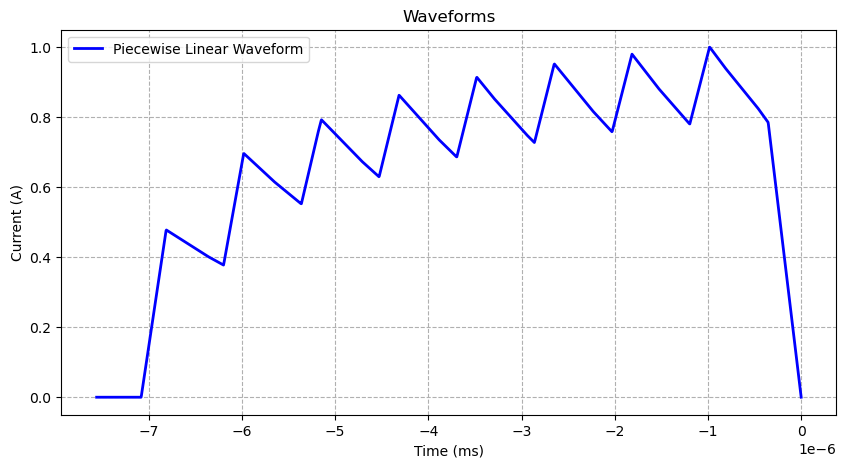

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt


with open ('vtem_et_silver_city.json', 'r') as file:
    data_points = json.load(file)

times_orig = np.array(data_points['times'])
currents = np.array(data_points['currents'])
current_times = np.array(data_points['current_times'])


PiecewiseLinearwaveform = tdem.sources.PiecewiseLinearWaveform(
    times=current_times,
    currents=currents
)


VTEMwaveform = tdem.sources.VTEMWaveform(
    off_time=7.56*1e-3,
    peak_time=5.5*1e-3,
    ramp_on_rate=3.0,
)

time_et = np.linspace(-7.56*1e-3, 0, 2000)  # 0–10 ms
time_plus = np.linspace(0, 7.56*1e-3, 2000)

current_piecewise = np.array([PiecewiseLinearwaveform.eval(t) for t in time_et])
current_vtem = np.array([VTEMwaveform.eval(t) for t in time_plus])

# Plot both waveforms
plt.figure(figsize=(10, 5))

plt.plot(time_et*1e-3, current_piecewise, 'b-', linewidth=2, label='Piecewise Linear Waveform')

# plt.plot(time*1e3, current_vtem, 'r--', linewidth=2, label='VTEM Waveform')

plt.xlabel("Time (ms)")
plt.ylabel("Current (A)")
plt.title("Waveforms")
plt.grid(True, linestyle='--')
plt.legend()
plt.show()


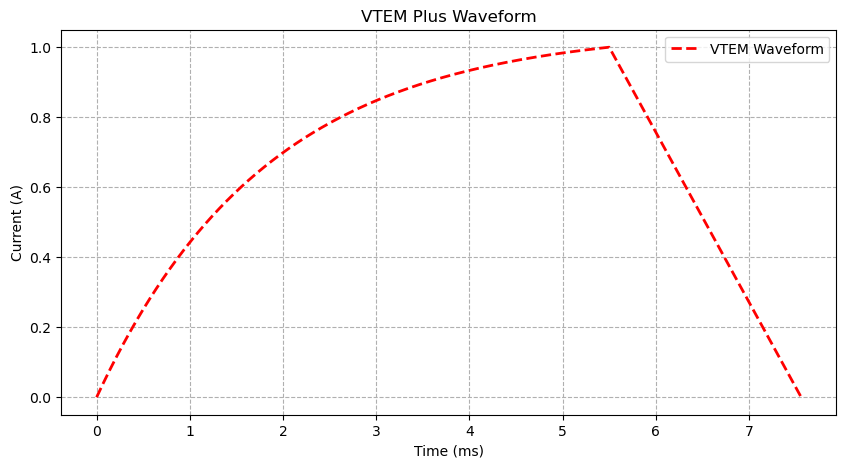

In [10]:
# Plot both waveforms
plt.figure(figsize=(10, 5))


plt.plot(time_plus*1e3, current_vtem, 'r--', linewidth=2, label='VTEM Waveform')

plt.xlabel("Time (ms)")
plt.ylabel("Current (A)")
plt.title("VTEM Plus Waveform")
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

In [11]:
# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=PiecewiseLinearwaveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

### **Define a 1D Layered Earth and the Model**

In [12]:
# Layer conductivities
layer_resistivities = np.r_[8.0, 15.31, 272.06, 56.0]
layer_resistivities_background = np.r_[8.0, 15.31, 15.31, 56.0]

# Layer thicknesses
layer_thicknesses = np.r_[20.0, 98.0,102]

# Number of layers
n_layers = len(layer_resistivities)

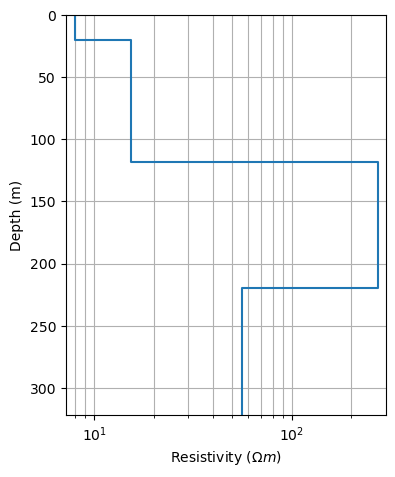

In [13]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivities, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
plt.show()

### **Define the Forward Simulation**

In [14]:
# Define model and mappings for the parametric model.
parametric_model = np.r_[layer_thicknesses, np.log(layer_resistivities)]
wire_map = maps.Wires(("thicknesses", n_layers - 1), ("log_resistivity", n_layers))
thicknesses_map = wire_map.thicknesses
log_resistivity_map = maps.ExpMap() * wire_map.log_resistivity

In [15]:
simulation_parametric = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknessesMap=thicknesses_map,
)

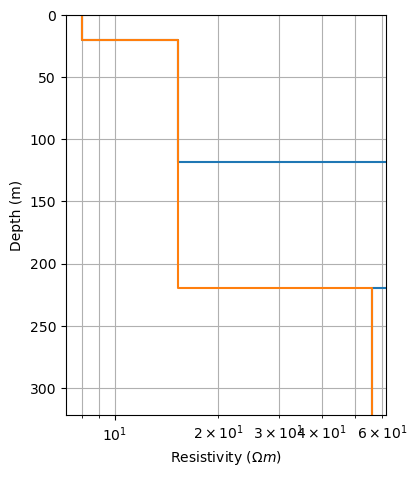

In [16]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivities, scale="log", ax=ax1)
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivities_background, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
plt.show()

In [17]:
m = np.r_[layer_thicknesses, np.log(layer_resistivities)]
m_bg= np.r_[layer_thicknesses, np.log(layer_resistivities_background)]

dpred = simulation_parametric.dpred(m)
dpred_bg = simulation_parametric.dpred(m_bg)

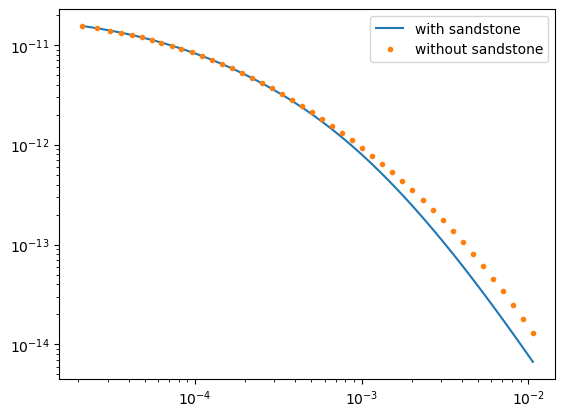

In [18]:
plt.loglog(times, dpred, label='with sandstone')
plt.loglog(times, dpred_bg, '.', label='without sandstone')
plt.legend()

### **Predict a 1D TDEM Data**

In [19]:
thickness_log = np.diff(depth)
res_log  = resistivity.copy()

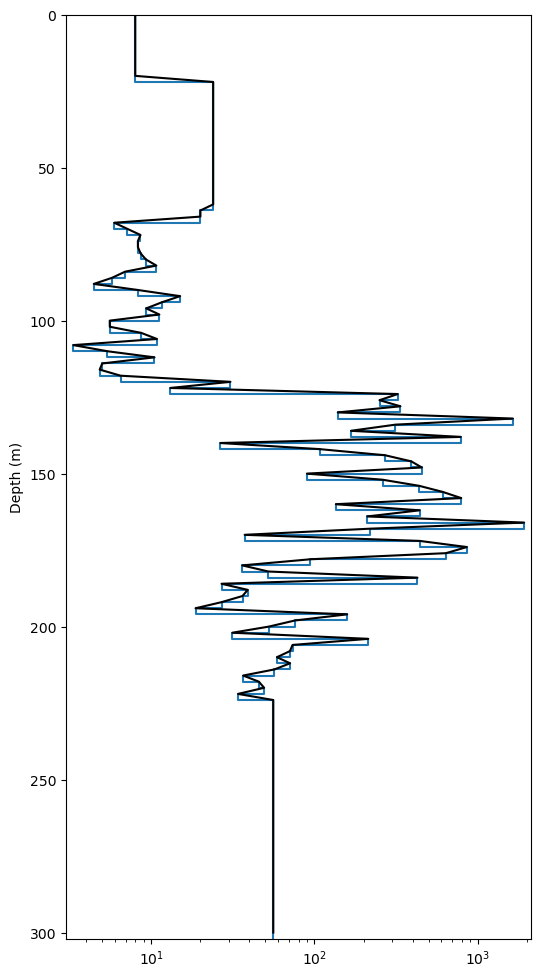

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,12))
plot_1d_layer_model(thickness_log, res_log, ax=ax)
ax.semilogx(resistivity, depth, "k-", lw=1.5, label='Raw Log')

(array([ 9., 27.,  5., 32., 49.,  5.,  8.,  9.,  5.,  2.]),
 array([0.52402495, 0.80005484, 1.07608473, 1.35211462, 1.62814451,
        1.9041744 , 2.18020429, 2.45623418, 2.73226407, 3.00829396,
        3.28432385]),
 <BarContainer object of 10 artists>)

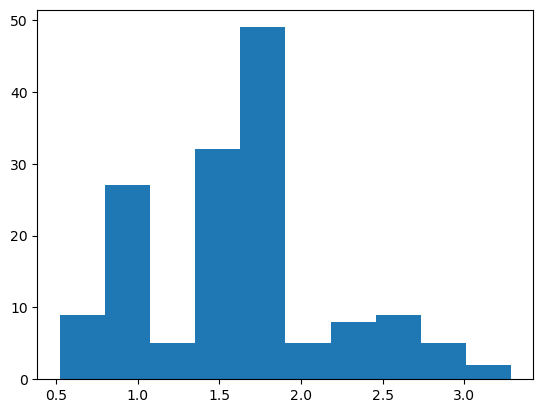

In [22]:
plt.hist(np.log10(resistivity))

In [23]:
simulation_simple = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=maps.IdentityMap(nP=len(res_log)),
    thicknesses=thickness_log,
)
dpred_log = simulation_simple.dpred(res_log)

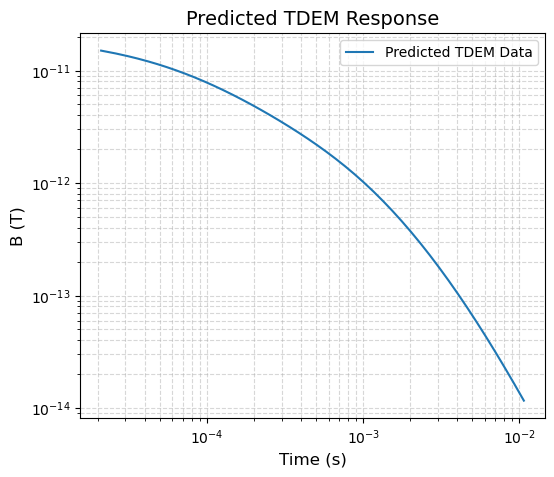

In [46]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.loglog(times, dpred_log, label="Predicted TDEM Data")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel(r"B (T)", fontsize=12)
ax.set_title("Predicted TDEM Response", fontsize=14)

ax.legend()
ax.grid(True, which="both", ls="--", alpha=0.5)


### **Assign Uncertainties and Define the Data**

In [25]:
# 1. Forward response from your log-based model
dpred_log = simulation_simple.dpred(res_log)

# 2. Define data uncertainties (5% relative error, always positive)
uncertainties = 0.05 * np.abs(dpred_log)

# 3. Create synthetic noisy data
noise = uncertainties * np.random.randn(*dpred_log.shape)
dobs = dpred_log + noise

# 4. Build SimPEG Data object
from simpeg import data

data_object = data.Data(
    survey,
    dobs=dobs,
    standard_deviation=uncertainties,
)


In [29]:
n_layers = len(thickness_log)+1


### **Starting Reference Model**

In [32]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log(60*np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

In [33]:
simulation_simple = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=maps.ExpMap(nP=len(res_log)),
    thicknesses=thickness_log,
)

### **Data Misfit Term**

In [34]:
dmis = data_misfit.L2DataMisfit(simulation=simulation_simple, data=data_object)
dmis.W = 1.0 / uncertainties

### **Creating a 1D Tensor Mesh**

In [35]:
# Define 1D cell widths
h = np.r_[thickness_log, thickness_log[-1]]
h = np.flipud(h)

# Create regularization mesh
mesh = TensorMesh([h], "N")
print(mesh)


  TensorMesh: 151 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    151       -302.00          0.00      2.00      2.00    1.00




### **Regularization, Optimization and Inverse Problem**

In [36]:
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.WeightedLeastSquares(mesh, mapping=reg_map, reference_model=reference_resistivity_model, reference_model_in_smooth=False)

# set reference model
reg.reference_model = reference_resistivity_model

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=10, maxIterLS=20, cg_maxiter=15, cg_rtol=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=1)
target = directives.TargetMisfit(chifact=1.)
# Options for outputting recovered models and predicted data for each beta.
save_dict = directives.SaveOutputDictEveryIteration()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    save_dict,
    beta_schedule,
    target
]
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_resistivity_model)

INFO: 
simpeg.InvProblem is setting bfgsH0 to the inverse of the reg.deriv2.
using the default solver SolverLU with the 'is_symmetric=True` option set.




Running inversion with SimPEG v0.25.0


/opt/conda/lib/python3.13/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_symmetric" for splu.
  self.kwargs = kwargs
/opt/conda/lib/python3.13/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
INFO: Directive TargetMisfit: Target data misfit is 45.0


============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  3.29e+00  1.37e+04  0.00e+00  1.37e+04                                 
   1  3.29e+00  1.95e+03  2.22e+02  2.68e+03    7.82e+02      1              
   2  1.65e+00  1.35e+02  3.57e+02  7.23e+02    1.38e+03      0              
   3  8.23e-01  1.06e+02  3.59e+02  4.01e+02    3.72e+02      1              
   4  4.12e-01  8.35e+01  3.61e+02  2.32e+02    3.54e+02      1   Skip BFGS  
   5  2.06e-01  6.13e+01  3.60e+02  1.35e+02    3.62e+02      1   Skip BFGS  
   6  1.03e-01  5.70e+01  3.60e+02  9.40e+01    2.99e+02      1   Skip BFGS  
   7  5.14e-02  5.47e+01  3.57e+02  7.31e+01    3.09e+02      2   Skip BFGS  
   8  2.57e-02  5.16e+01  3.56e+02  6.08e+01    3.11e+02      3   Skip BFGS  
   9  1.29e-02  4.93e+01  3.54e+02  5.39e+01    2.97e+02      3

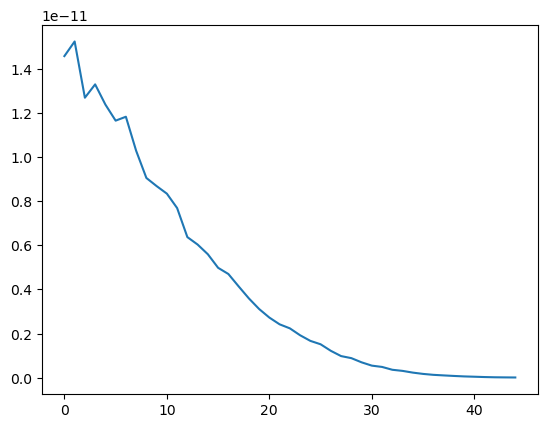

In [37]:
plt.plot(dobs)

### **Inversion Outputs: True Model vs Recovered Model**

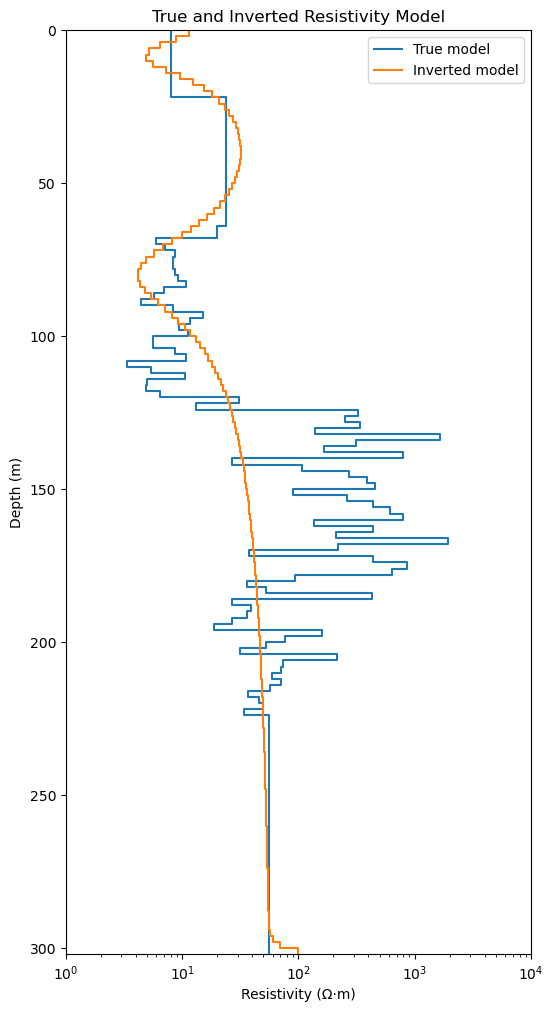

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

# Plot observed model
plot_1d_layer_model(thickness_log, res_log, ax=ax)

# Plot recovered/inverted model
plot_1d_layer_model(thickness_log, np.exp(recovered_model), ax=ax)

# Log x-axis (resistivity)
ax.set_xlim(1, 1e4)
ax.set_xscale("log")

# Axis labels and title
ax.set_xlabel(r"Resistivity (Ω·m)")
ax.set_ylabel("Depth (m)")
ax.set_title("True and Inverted Resistivity Model")

# Legend
ax.legend(["True model", "Inverted model"], loc="upper right")


### **Predicted Data vs Observed Data**

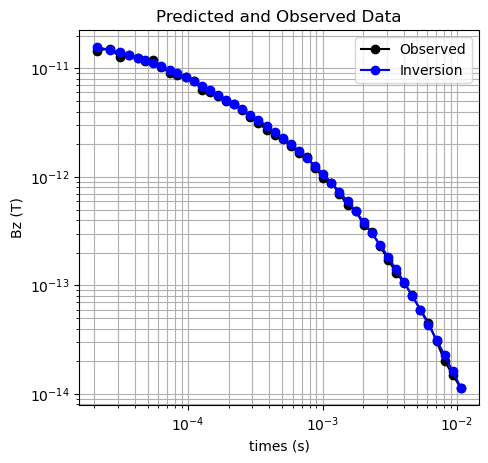

In [39]:
dpred = simulation_simple.dpred(recovered_model)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred), "b-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "Inversion"], loc="upper right")
plt.show()